In [2]:
import obspy
import obsplus

In [3]:
!which python

/home/dsiervo/anaconda3/bin/python


In [4]:
#%time cat = obspy.read_events('main_events_pruned.xml')

# Using pandas_read_xml

In [5]:
import pandas_read_xml as pdx
import pandas as pd
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization

sns.set(style="whitegrid", font_scale=1.4)
%matplotlib inline

In [38]:
df_ev = pdx.read_xml('main_events_pruned.xml', ['seiscomp', 'EventParameters', 'event'])
df_or = pdx.read_xml('main_events_pruned.xml', ['seiscomp', 'EventParameters', 'origin'])

df_or.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2759 entries, 0 to 2758
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   @publicID         2759 non-null   object
 1   time              2759 non-null   object
 2   latitude          2759 non-null   object
 3   longitude         2759 non-null   object
 4   depth             2759 non-null   object
 5   methodID          2759 non-null   object
 6   earthModelID      2759 non-null   object
 7   quality           2759 non-null   object
 8   uncertainty       2759 non-null   object
 9   evaluationMode    2759 non-null   object
 10  creationInfo      2759 non-null   object
 11  arrival           2759 non-null   object
 12  stationMagnitude  2759 non-null   object
 13  magnitude         2759 non-null   object
dtypes: object(14)
memory usage: 301.9+ KB


In [7]:
def get_mag(x, key):
    return float(x[0]['magnitude'][key])

def get_mag_count(x):
    return int(x[0]['stationCount'])

def get_from_dict(x, key, time=False):
    if not time:
        try:
            return float(x[key])
        except KeyError:
            return 'fixed'
    else:
        return x[key]

def get_region_author(x, key):
    return x[key]

In [8]:
def load_prepare_data(xml_name):
    """
    Prepare dataframe with useful information from event xml

    Parameters
    ----------
    xml_name : str
        Name of seiscomp like event xml file

    Returns
    -------
    pandas.Dataframe
        Dataframe with useful information about events in the xml
    """
    # loading events dataframe
    df = pdx.read_xml('main_events_pruned.xml', ['seiscomp', 'EventParameters', 'event'])
    # loading origins dataframe
    df_or = pdx.read_xml('main_events_pruned.xml', ['seiscomp', 'EventParameters', 'origin'])

    # preparing events dataframe
    df['region'] = df['description'].apply(get_region_author, key='text')
    df['author'] = df['creationInfo'].apply(get_region_author, key='author')
    df = df[['@publicID', 'preferredOriginID', 'author', 'region']]

    # preparing origins dataframe
    df_or['lat'] = df_or['latitude'].apply(get_from_dict, key='value')
    df_or['lon'] = df_or['longitude'].apply(get_from_dict, key='value')
    df_or['z'] = df_or['depth'].apply(get_from_dict, key='value')
    df_or['orig_time'] = df_or['time'].apply(get_from_dict, key='value', time=True)
    df_or['orig_time'] = pd.to_datetime(df_or['orig_time'])

    df_or['lat_e'] = df_or['latitude'].apply(get_from_dict, key='uncertainty')
    df_or['lon_e'] = df_or['longitude'].apply(get_from_dict, key='uncertainty')
    df_or['z_e'] = df_or['depth'].apply(get_from_dict, key='uncertainty')
    df_or['t_e'] = df_or['time'].apply(get_from_dict, key='uncertainty')

    df_or['min_dis'] = df_or['quality'].apply(get_from_dict, key='minimumDistance')
    df_or['phasecount'] = df_or['quality'].apply(get_from_dict, key='usedPhaseCount')
    df_or['stationcount'] = df_or['quality'].apply(get_from_dict, key='usedStationCount')

    df_or['mag'] = df_or['magnitude'].apply(get_mag, key='value')
    df_or['mag_e'] = df_or['magnitude'].apply(get_mag, key='uncertainty')
    df_or['mag_count'] = df_or['magnitude'].apply(get_mag_count)

    df_or = df_or[['@publicID', 'orig_time', 'mag', 'lat', 'lon', 'z',
                   'lat_e', 'lon_e', 'z_e', 'min_dis', 'phasecount',
                   'stationcount', 'mag_e', 't_e']]
    df_or.rename(columns={'@publicID' : 'originID'}, inplace=True)

    # mergin the two dataframes
    df_merge = pd.merge(df, df_or, how='inner',
                        left_on='preferredOriginID',
                        right_on='originID')
    
    return df_merge


In [9]:
%time df = load_prepare_data('main_events_pruned.xml')

CPU times: user 14.8 s, sys: 504 ms, total: 15.4 s
Wall time: 15.4 s


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2759 entries, 0 to 2758
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   @publicID          2759 non-null   object             
 1   preferredOriginID  2759 non-null   object             
 2   author             2759 non-null   object             
 3   region             2759 non-null   object             
 4   originID           2759 non-null   object             
 5   orig_time          2759 non-null   datetime64[ns, UTC]
 6   mag                2759 non-null   float64            
 7   lat                2759 non-null   float64            
 8   lon                2759 non-null   float64            
 9   z                  2759 non-null   float64            
 10  lat_e              2759 non-null   float64            
 11  lon_e              2759 non-null   float64            
 12  z_e                2759 non-null   object       

In [11]:
df.head(2)

,@publicID,preferredOriginID,author,region,originID,orig_time,mag,lat,lon,z,lat_e,lon_e,z_e,min_dis,phasecount,stationcount,mag_e,t_e
0,SGC2020fyjjjd,Origin/20210126110624.8871.36281,AI_picker,"San Gil - Santander, Colombia",Origin/20210126110624.8871.36281,2020-03-25 02:11:37.351789+00:00,3.241014,6.548205,-73.097939,193.720413,11.50899,8.354490,15.7779,2.009451,13.0,8.0,0.210008,1.048404
1,SGC2020fypgpj,Origin/20210126110625.287887.36906,AI_picker,"Mesetas - Meta, Colombia",Origin/20210126110625.287887.36906,2020-03-25 05:09:27.103041+00:00,1.822526,3.453711,-74.212387,3.306143,3.94858,2.546874,3.21714,0.189329,8.0,5.0,0.585646,0.638045


<AxesSubplot:ylabel='Frequency'>

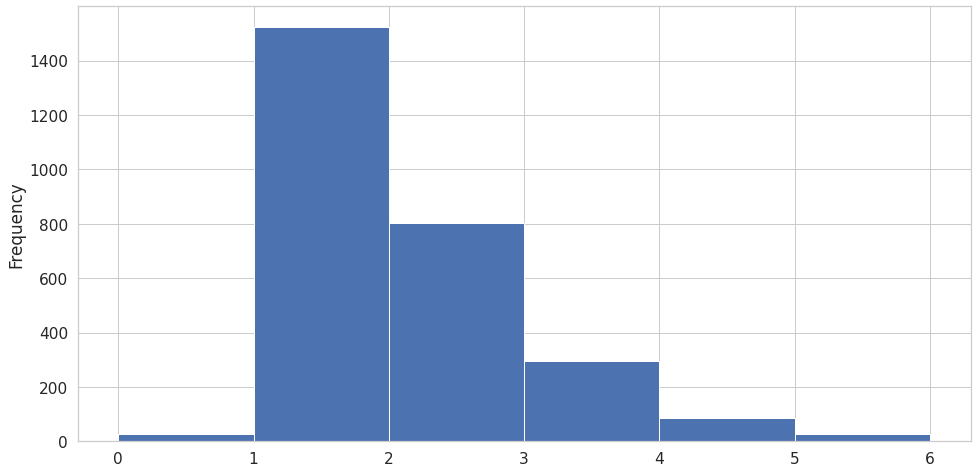

In [12]:
df.mag.plot(kind='hist', bins=range(7), figsize=(16, 8))

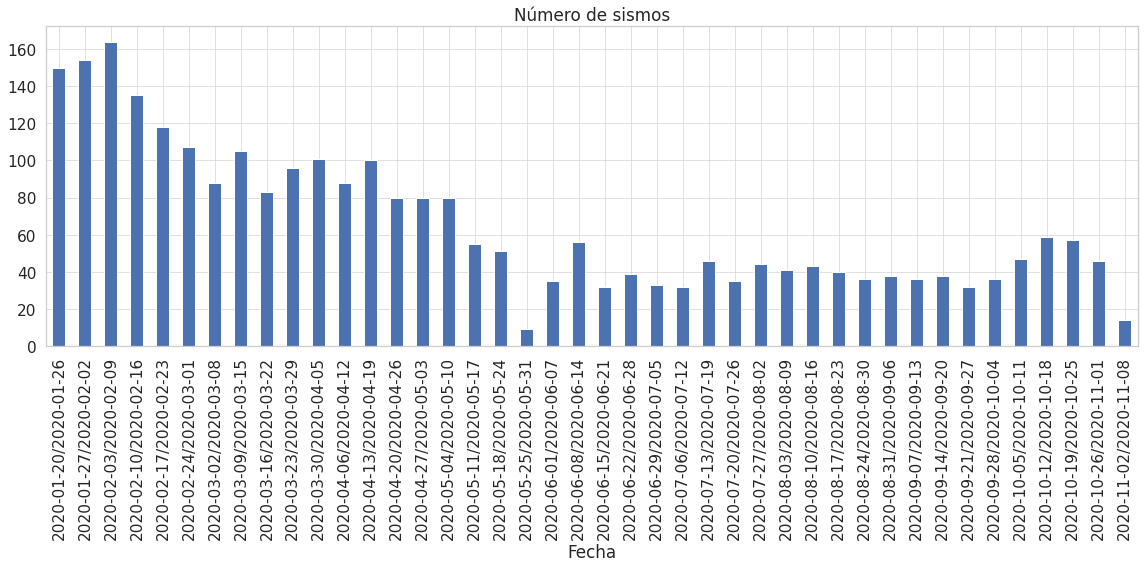

In [23]:
ax = df['orig_time'].groupby([df['orig_time'].dt.to_period('1w')]).count().plot(kind='bar',
	                                                          legend=False,
	                                                          figsize=(16, 8))
ax.set_xlabel('Fecha')
ax.set_title(u"Número de sismos")
ax.set_axisbelow(True)
ax.grid(alpha=0.6)
fig = ax.get_figure()
plt.tight_layout()

In [37]:
df['orig_time'] = df['orig_time'].astype('datetime64[ns]')
df_ = df.query('orig_time > "2020-10-12" and orig_time <= "2020-10-18"')[['@publicID', 'region', 'orig_time', 'mag', 'z', 'phasecount', 't_e']]
df_.sort_values(by=['orig_time'])

,@publicID,region,orig_time,mag,z,phasecount,t_e
2742,SGC2020udhlor,"Pinchote - Santander, Colombia",2020-10-12 01:45:17.631812,3.852571,196.869797,9.0,1.471371
2743,SGC2020uegdli,"Sipí - Chocó, Colombia",2020-10-12 14:10:09.874791,1.954448,8.957428,7.0,1.545265
2744,SGC2020uehxgv,"El Dovio - Valle del Cauca, Colombia",2020-10-12 15:03:20.674756,1.693485,50.913658,6.0,1.845800
2745,SGC2020uekmho,"Cajamarca - Tolima, Colombia",2020-10-12 16:21:07.742155,1.113569,3.575392,7.0,0.824674
2746,SGC2020ueqdsz,"Mogotes - Santander, Colombia",2020-10-12 19:12:13.626538,3.003891,187.202683,8.0,1.462594
2747,SGC2020uesnnt,"Yotoco - Valle del Cauca, Colombia",2020-10-12 20:23:56.606396,2.375411,95.940338,7.0,1.406397
2748,SGC2020ueuhpg,"La Victoria - Valle del Cauca, Colombia",2020-10-12 21:17:23.514792,1.911250,5.000000,8.0,1.260004
2749,SGC2020ufcecz,"Victoria - Caldas, Colombia",2020-10-13 01:14:44.338233,1.992521,22.680054,7.0,1.602018
2750,SGC2020ufguqs,"Cabuyaro - Meta, Colombia",2020-10-13 03:34:36.497842,2.114492,5.000000,9.0,1.089746
2751,SGC2020ufhary,"Moniquirá - Boyacá, Colombia",2020-10-13 03:41:37.514069,2.189108,140.803024,7.0,1.428053


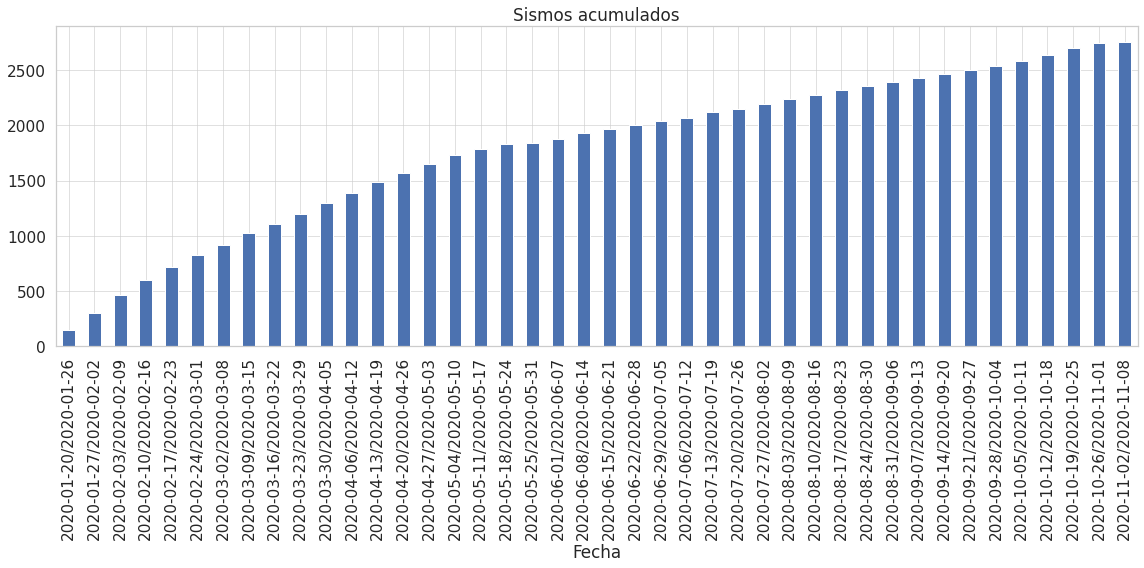

In [30]:
ax = df['orig_time'].groupby([df['orig_time'].dt.to_period('1w')]).count().cumsum().plot(kind='bar',
	                                                          legend=False,
	                                                          figsize=(16, 8))
ax.set_xlabel('Fecha')
ax.set_title(u"Sismos acumulados")
ax.set_axisbelow(True)
ax.grid(alpha=0.6)
fig = ax.get_figure()
plt.tight_layout()

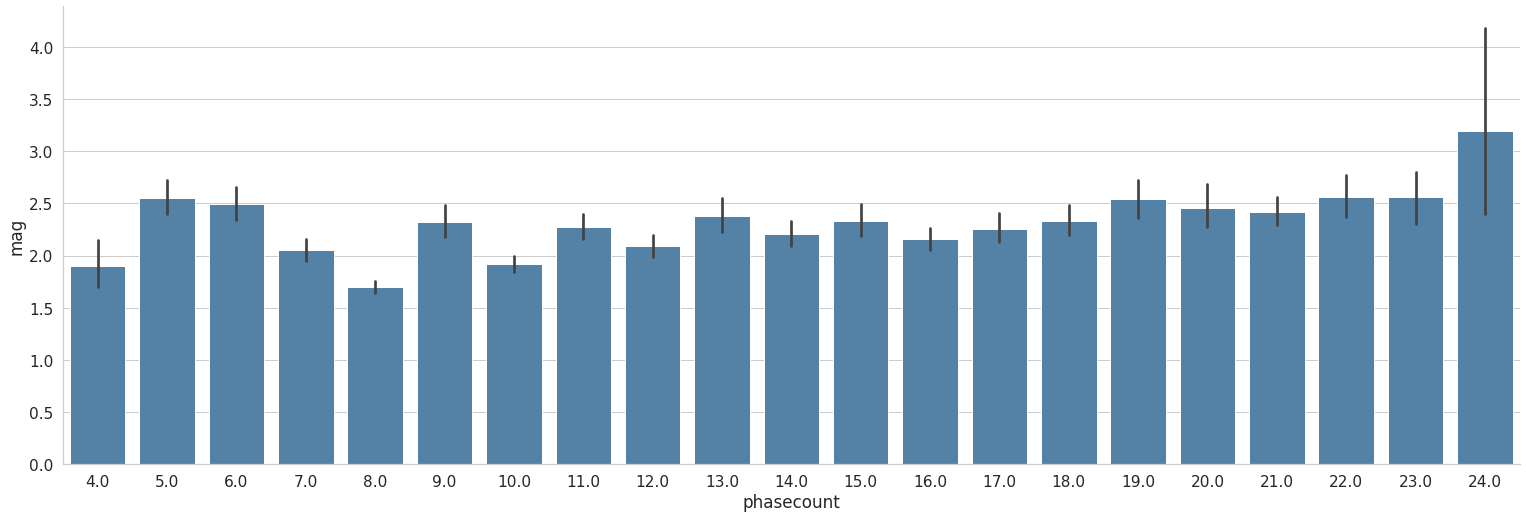

In [14]:
sns.catplot(x='phasecount', y='mag', kind='bar', height=7, aspect=3, color='steelblue', data=df)

# Saving the dataframe in csv

In [15]:
df.to_csv('all_events.csv')